In [2]:
import osmnx as ox
import networkx as nx
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from shapely import MultiPolygon, Polygon
from shapely.ops import unary_union
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch
import matplotlib.colors as mcolors

In [3]:
date = '20250706'
timezone = "t00z"
base_path = rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\try_clean\good_candidates\{date}\{timezone}\outputs'

rain_path = rf'{base_path}\RAIN.nc'
wind_speed = rf'{base_path}\WSPD10.nc'
wind_direction = rf'{base_path}\WDIR10.nc'
heat_index = rf'{base_path}\T2.nc'
relative_humidity = rf'{base_path}\RH2.nc'

lat_min, lat_max = 41.61, 42.04
lon_min, lon_max = -88.03, -87.30

# Slice the data to the area of interest
def slice_data(nc_file, lat_min, lat_max, lon_min, lon_max):
    lats = nc_file.variables['XLAT'][:]
    lons = nc_file.variables['XLONG'][:]
    
    lat_indices = np.where((lats >= lat_min) & (lats <= lat_max))[0]
    lon_indices = np.where((lons >= lon_min) & (lons <= lon_max))[0]
    
    return lat_indices, lon_indices

# Load the netCDF files
rain_nc = nc.Dataset(rain_path)
wind_speed_nc = nc.Dataset(wind_speed)
wind_direction_nc = nc.Dataset(wind_direction)
heat_index_nc = nc.Dataset(heat_index)
relative_humidity_nc = nc.Dataset(relative_humidity)

# Slice the data
lat_indices, lon_indices = slice_data(rain_nc, lat_min, lat_max, lon_min, lon_max)
rain_data = rain_nc.variables['RAIN'][0, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
wind_speed_data = wind_speed_nc.variables['WSPD10'][0, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
wind_direction_data = wind_direction_nc.variables['WDIR10'][0, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
heat_index_data = heat_index_nc.variables['T2'][0, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
relative_humidity_data = relative_humidity_nc.variables['RH2'][0, lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

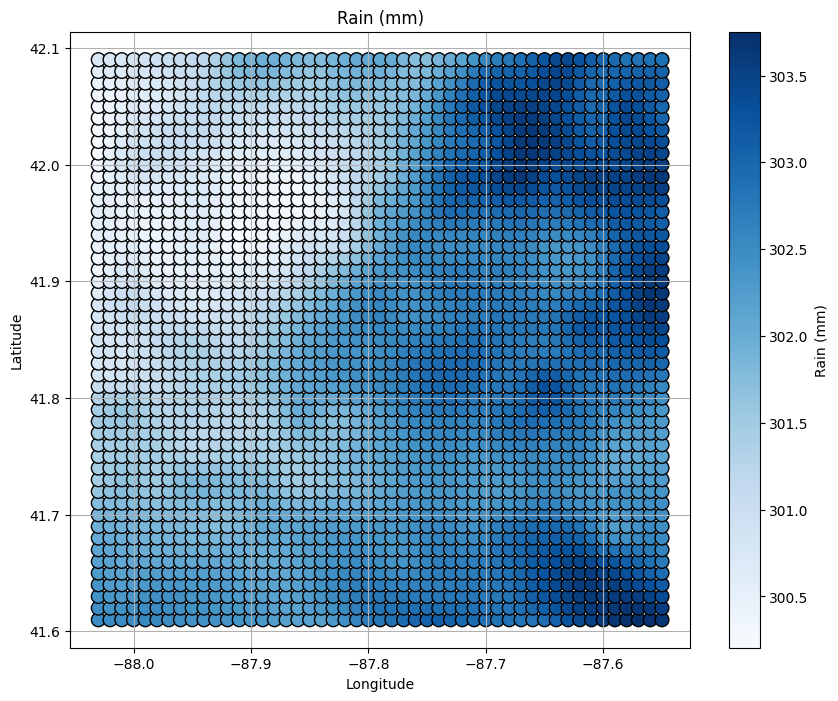

In [ ]:
# Map all the data
def map_data(data, lat_indices, lon_indices, lat_min, lon_min, lat_res=0.01, lon_res=0.01):
    points = []
    values = []
    for i, lat_idx in enumerate(range(lat_indices.min(), lat_indices.max()+1)):
        for j, lon_idx in enumerate(range(lon_indices.min(), lon_indices.max()+1)):
            lat = lat_min + i * lat_res
            lon = lon_min + j * lon_res
            points.append((lon, lat))
            values.append(data[i, j])
    return points, values
rain_points, rain_values = map_data(rain_data, lat_indices, lon_indices, lat_min, lon_min)
wind_speed_points, wind_speed_values = map_data(wind_speed_data, lat_indices, lon_indices, lat_min, lon_min)
wind_direction_points, wind_direction_values = map_data(wind_direction_data, lat_indices, lon_indices, lat_min, lon_min)
heat_index_points, heat_index_values = map_data(heat_index_data, lat_indices, lon_indices, lat_min, lon_min)
relative_humidity_points, relative_humidity_values = map_data(relative_humidity_data, lat_indices, lon_indices, lat_min, lon_min)   

# Show the data on a map
def plot_data(points, values, title, cmap='viridis'):
    lons, lats = zip(*points)
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(lons, lats, c=values, cmap=cmap, s=100, edgecolor='k')
    plt.colorbar(sc, label=title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid()
    plt.show()
    
plot_data(rain_points, rain_points, 'Rain (mm)', cmap='Blues')



In [40]:
# Save all humidity data to a csv

import pandas as pd
humidity_df = pd.DataFrame(wind_speed_points, columns=['Longitude', 'Latitude'])
humidity_df['wind_speed'] = wind_speed_values
# humidity_df.to_csv(rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\relative_humidity.csv', index=False)
# humidity_df.to_csv(rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\heat.csv', index=False)
# humidity_df.to_csv(rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\rain.csv', index=False)
humidity_df.to_csv(rf'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\wind_speed.csv', index=False)

In [47]:
# Modify the data

# Load your dataset
csv_path = r'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\wind_speed.csv'
df = pd.read_csv(csv_path)

Latitude_bottom = 41.65
Latitude_top = Latitude_bottom + 0.35
Longitude_top = -87.65
Longitude_bottom = Longitude_top - 0.05
mask = (df['Latitude'] >= Latitude_bottom) & (df['Latitude'] <= Latitude_top) & (df['Longitude'] >= Longitude_bottom) & (df['Longitude'] <= Longitude_top)

# Add +6 to Wind Speed for that range
df.loc[mask, 'wind_speed'] += 6

# Save back to CSV
df.to_csv(csv_path, index=False)

print("✅ Updated wind speed values saved successfully.")


✅ Updated wind speed values saved successfully.


   Longitude  Latitude  wind_speed
0     -88.03     41.61    2.624435
1     -88.02     41.61    2.599937
2     -88.01     41.61    2.569461
3     -88.00     41.61    2.533584
4     -87.99     41.61    2.504372


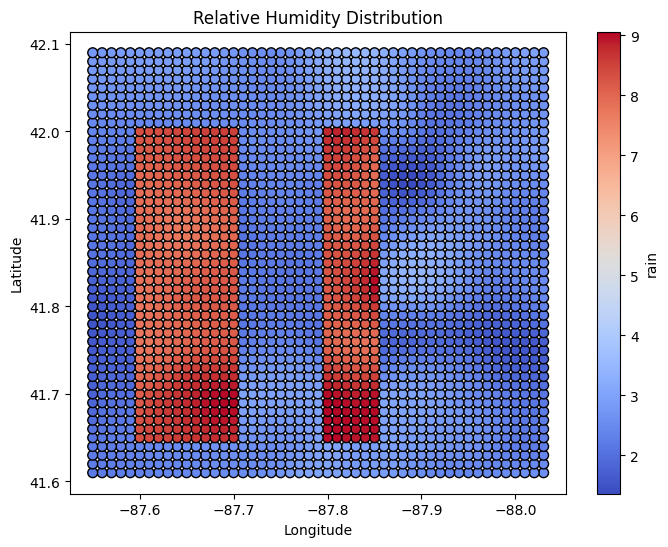

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the CSV
csv_path = r'C:\Users\elchi\Desktop\UIC_Chicago\Knowledge_graph\Backend\DatasetCreation\wind_speed.csv'
df = pd.read_csv(csv_path)

# 2️⃣ Check the data
print(df.head())

# 3️⃣ Create the plot
plt.figure(figsize=(8, 6))

# Use a scatter plot where color represents humidity
sc = plt.scatter(
    df['Longitude'], 
    df['Latitude'], 
    c=df['wind_speed'], 
    cmap='coolwarm', 
    s=50,
    edgecolor='k'
)

# 4️⃣ Add colorbar and labels
plt.colorbar(sc, label='rain')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Relative Humidity Distribution')

# Optional: invert x-axis if you want west (negative longitude) to be on the left
plt.gca().invert_xaxis()

plt.show()

